In [9]:
import numpy as np
import scipy.linalg as la

## ❓ Develop, and if possible test and evaluate, an algorithm that solves the one-group, steady-state, slab geometry, fixed source diffusion equation.  Assume a spatial mesh is imposed on the problem and that a finite volume or finite difference discretization is used to derive the linear system of equations to be solved. 

# $- D \frac{d^2 \phi(x)}{dx^2} + \Sigma_a \, \phi(x) = S$


In [10]:
N = 3
n = N - 1
L = 10.0
dx = L / N
D = 1.0
xs_a = 0.1
S = 1.0 

def diffusion_matrix(D, xs_a): #finite difference
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2 * D / dx**2 + xs_a
        if i > 0:
            A[i, i - 1] = -D / dx**2
        if i < n - 1:
            A[i, i + 1] = -D / dx**2
    return A

A = diffusion_matrix(D, xs_a)
b = np.full(n, S * dx)
b_norm = b / np.linalg.norm(b)

classical_solution = la.solve(A, b_norm)
ref_solution = classical_solution / np.linalg.norm(classical_solution)
print("Classical solution:", classical_solution)
print("Reference solution:", ref_solution)
print("A", A)

Classical solution: [3.72161464 3.72161464]
Reference solution: [0.70710678 0.70710678]
A [[ 0.28 -0.09]
 [-0.09  0.28]]


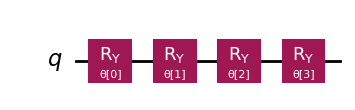

In [11]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
size = n
nqbit = int(np.log2(size))
ansatz = RealAmplitudes(nqbit, entanglement="full", reps=3, insert_barriers=False)
ansatz.decompose().draw("mpl")

In [12]:

from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

# instantiate an estimator primitive
estimator = Estimator()

# create a logger
log = VQLSLog([], [])

# create the vqls solver
options = {"matrix_decomposition": "pauli", "verbose": True}
vqls = VQLS(estimator, ansatz, opt.CG(maxiter=200), options=options)

/var/folders/4c/d6_2w_n17m107k5fsh4ggp3w0000gn/T/ipykernel_31019/1189491015.py:6: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [13]:
res = vqls.solve(A, b)


100%|██████████| 4/4 [00:00<00:00, 489.70it/s]


Text(0.5, 0, 'Iterations')

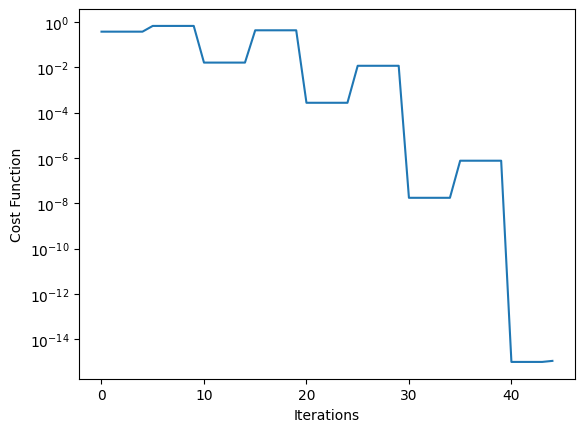

In [14]:
import matplotlib.pyplot as plt

plt.semilogy(vqls.logger.values)
plt.ylabel("Cost Function")
plt.xlabel("Iterations")

In [15]:
from qiskit.quantum_info import Statevector

vqls_solution = np.real(Statevector(res.state).data)

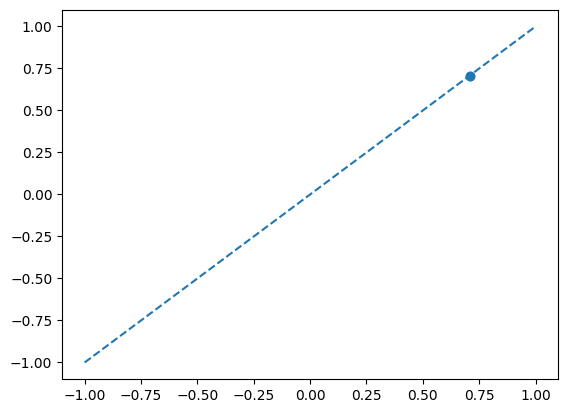

In [16]:
ref_solution = np.linalg.solve(A, b / np.linalg.norm(b))
ref_solution = ref_solution / np.linalg.norm(ref_solution)

plt.scatter(ref_solution, vqls_solution)
plt.plot([-1, 1], [-1, 1], "--")

In [17]:
print(ref_solution)

[0.70710678 0.70710678]


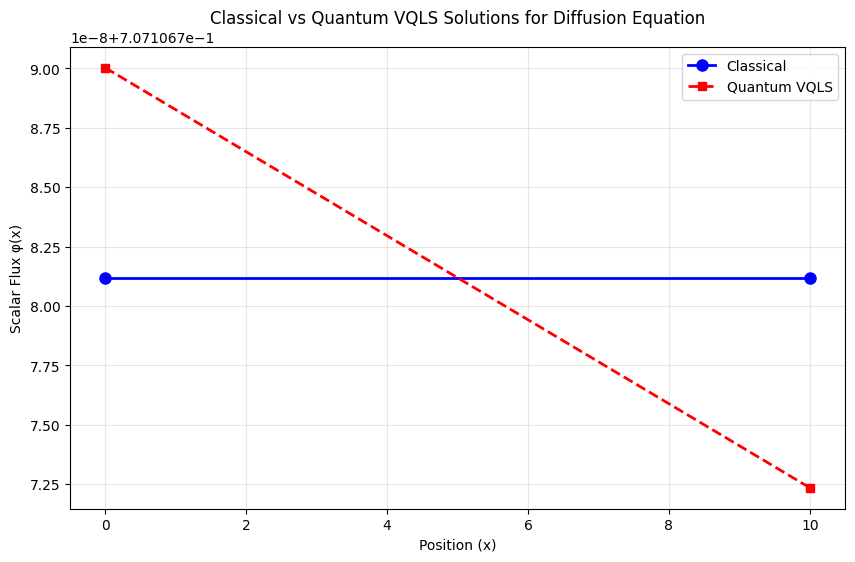

In [19]:
import matplotlib.pyplot as plt
import numpy as np


x = np.linspace(0, 10, 2)

plt.figure(figsize=(10, 6))
plt.plot(x, ref_solution, 'b-o', label='Classical', markersize=8, linewidth=2)
plt.plot(x, vqls_solution, 'r--s', label='Quantum VQLS', markersize=6, linewidth=2)

plt.errorbar(x, vqls_solution, fmt='none', 
            ecolor='red', alpha=0.3, capsize=5)

plt.xlabel('Position (x)')
plt.ylabel('Scalar Flux φ(x)')
plt.title('Classical vs Quantum VQLS Solutions for Diffusion Equation')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()